# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 16.0MB/s 


# Evn

In [19]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [20]:
from sklearn.decomposition import PCA
#눈에 보이는 차원수를 줄여줌.

In [21]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [22]:
!nvidia-smi

Wed Jan 27 02:19:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W /  70W |    229MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Word2Vec (Skip-gram)


## 모델링

In [23]:
# 입력 문장
sentences = """나는 오늘 기분이 좋아
나는 오늘 우울해"""

# 문장을 띄어쓰기 단위로 분할
words = sentences.split()

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)
word_to_id

{'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5}

In [24]:
# 입력(c), 출력(o) 정의
#inputs << 중심단어 labels << 주변단어
inputs = np.array([word_to_id['나는']])
labels = np.array([word_to_id['기분이']])
inputs, labels

(array([2]), array([4]))

In [27]:
# center word embedding
V = tf.keras.layers.Embedding(len(word_to_id), 4)
v = V(inputs)
v

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01098528,  0.0306937 , -0.00226969,  0.00098121]],
      dtype=float32)>

In [28]:
# weight of center matrix
# 중심단어에 대한 중요도 판단 맥트릭스
V.get_weights()

[array([[-0.01746353, -0.03612994,  0.01480493, -0.01959816],
        [-0.01632367, -0.03698195,  0.02057973,  0.02185966],
        [-0.01098528,  0.0306937 , -0.00226969,  0.00098121],
        [-0.02956598,  0.03029363,  0.0141835 ,  0.04274947],
        [ 0.00848954,  0.0289362 ,  0.02202288, -0.01791685],
        [ 0.04709952,  0.03384167,  0.0277797 ,  0.04307822],
        [-0.02606037, -0.04369395, -0.00189743, -0.02968305]],
       dtype=float32)]

In [32]:
# outer word embedding transpose
# 외부단어에 대한 값들 embedding 하기
U = tf.keras.layers.Dense(len(word_to_id), use_bias= False)
vu = U(v)
vu

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.0106569 ,  0.00260676, -0.01049954,  0.01459647,  0.00171971,
         0.00785181, -0.02110647]], dtype=float32)>

In [37]:
# weight of outer matrix transpose
# 외부단어 중요도 전치행렬??
U.get_weights()[0].shape, U.get_weights()[0]

((4, 7),
 array([[ 0.60548824,  0.24767327, -0.44403577, -0.25346276, -0.6718174 ,
          0.02926779,  0.01265711],
        [-0.17883301,  0.12376595, -0.5641975 ,  0.34614342, -0.15876192,
          0.22491145, -0.68085194],
        [-0.59742516, -0.38316748, -0.5846163 , -0.73337275,  0.33341056,
         -0.63082266,  0.05431461],
        [ 0.13008189,  0.67163044,  0.6247528 , -0.48596415, -0.03125191,
         -0.16490352,  0.05474198]], dtype=float32))

In [39]:
WU = U.get_weights()[0]
np.dot(v, WU[:,1])

array([0.00260676], dtype=float32)

In [40]:
# exp(uv) / sum(exp(uv))
# cross_entropy 구하기
vu_prob = tf.nn.softmax(vu)
vu_prob


<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.1416466 , 0.14353786, 0.14166889, 0.1452692 , 0.1434106 ,
        0.1442927 , 0.14017417]], dtype=float32)>

In [41]:
# outer word embedding transpose & softmax
U = tf.keras.layers.Dense(len(word_to_id), use_bias = False, activation=tf.nn.softmax)
vu_prob = U(v)
vu_prob

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.14231472, 0.14189054, 0.14316265, 0.14672291, 0.14135034,
        0.13954465, 0.14501418]], dtype=float32)>

In [43]:
# weight of outer matrix transpose
U.get_weights()[0].shape

(4, 7)

In [44]:
# label one hot
vu_label = tf.one_hot(labels, len(word_to_id))

In [45]:
# cross entroyp loss
# 각 라벨의 기대값의 총합을 구하기.
loss = - vu_label * tf.math.log(vu_prob)
loss

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.       , 0.       , 0.       , 0.       , 1.9565138, 0.       ,
        0.       ]], dtype=float32)>

In [46]:
# sparse_categorical_crossentropy
tf.keras.losses.sparse_categorical_crossentropy(labels, vu_prob)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.9565136], dtype=float32)>

In [51]:
def build_model(n_vocab, d_model):
    tokens = tf.keras.layers.Input(shape=(1,))

    V = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab, d_model)
    v = V(tokens)  # (bs, 1, d_model)
    # 
    # 단어예측 ()
    U = tf.keras.layers.Dense(len(word_to_id), use_bias = False, activation=tf.nn.softmax)
    vu_prob = U(v)


    model = tf.keras.Model(inputs=tokens, outputs=vu_prob)
    return model, V

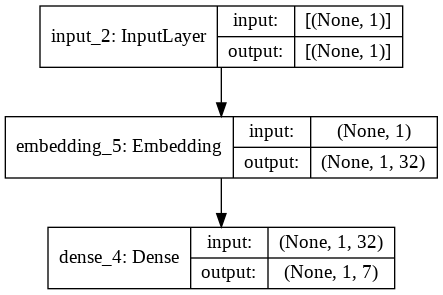

In [52]:
# 모델 생성
model, V = build_model(len(word_to_id), 32)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## 데이터

In [53]:
# 학습할 말뭉치
text = """수학은 수식이 복잡해서 어렵다
수학은 공식이 많아서 어렵다
수학은 수식이 이해되면 쉽다
수학은 공식이 능통하면 쉽다
영어는 단어가 많아서 어렵다
영어는 듣기가 복잡해서 어렵다
영어는 단어가 이해되면 쉽다
영어는 듣기가 능통하면 쉽다
국어는 지문이 복잡해서 어렵다
국어는 한문이 많아서 어렵다
국어는 지문이 이해되면 쉽다
국어는 한문이 능통하면 쉽다"""

## Vocabulary

In [ ]:
# 띄어쓰기 기준 단어 목록
words = list(dict.fromkeys(text.split()))
words

In [ ]:
# 각 단어별 고유한 번호 부여
# 중복 제거 및 데이터화
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)
word_to_id

In [ ]:
# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}
id_to_word

## 학습용 데이터 생성

In [57]:
# 줄바꿈 단위로 문장 분리
sentences = text.split("\n")
sentences

['수학은 수식이 복잡해서 어렵다',
 '수학은 공식이 많아서 어렵다',
 '수학은 수식이 이해되면 쉽다',
 '수학은 공식이 능통하면 쉽다',
 '영어는 단어가 많아서 어렵다',
 '영어는 듣기가 복잡해서 어렵다',
 '영어는 단어가 이해되면 쉽다',
 '영어는 듣기가 능통하면 쉽다',
 '국어는 지문이 복잡해서 어렵다',
 '국어는 한문이 많아서 어렵다',
 '국어는 지문이 이해되면 쉽다',
 '국어는 한문이 능통하면 쉽다']

In [58]:
# 띄어쓰기 단위로 단어 분리
tokens = []
for sentence in sentences:
    tokens.append(sentence.split())
tokens

[['수학은', '수식이', '복잡해서', '어렵다'],
 ['수학은', '공식이', '많아서', '어렵다'],
 ['수학은', '수식이', '이해되면', '쉽다'],
 ['수학은', '공식이', '능통하면', '쉽다'],
 ['영어는', '단어가', '많아서', '어렵다'],
 ['영어는', '듣기가', '복잡해서', '어렵다'],
 ['영어는', '단어가', '이해되면', '쉽다'],
 ['영어는', '듣기가', '능통하면', '쉽다'],
 ['국어는', '지문이', '복잡해서', '어렵다'],
 ['국어는', '한문이', '많아서', '어렵다'],
 ['국어는', '지문이', '이해되면', '쉽다'],
 ['국어는', '한문이', '능통하면', '쉽다']]

In [67]:
# center-outer 생성
# 데이터 전처리 같은 부분.
window_size = 2
word_pairs = []
for line_token in tokens:
    for i in range(len(line_token)):
      o_1 = max(0, i - window_size)
      o_2 = min(len(line_token) - 1 , i + window_size)
      c = line_token[i]
      o = [line_token[j] for j in range(o_1, o_2 + 1) if j != i]
      word_pairs.append({"c": c, "o": o})


print(len(word_pairs))
word_pairs

48


[{'c': '수학은', 'o': ['수식이', '복잡해서']},
 {'c': '수식이', 'o': ['수학은', '복잡해서', '어렵다']},
 {'c': '복잡해서', 'o': ['수학은', '수식이', '어렵다']},
 {'c': '어렵다', 'o': ['수식이', '복잡해서']},
 {'c': '수학은', 'o': ['공식이', '많아서']},
 {'c': '공식이', 'o': ['수학은', '많아서', '어렵다']},
 {'c': '많아서', 'o': ['수학은', '공식이', '어렵다']},
 {'c': '어렵다', 'o': ['공식이', '많아서']},
 {'c': '수학은', 'o': ['수식이', '이해되면']},
 {'c': '수식이', 'o': ['수학은', '이해되면', '쉽다']},
 {'c': '이해되면', 'o': ['수학은', '수식이', '쉽다']},
 {'c': '쉽다', 'o': ['수식이', '이해되면']},
 {'c': '수학은', 'o': ['공식이', '능통하면']},
 {'c': '공식이', 'o': ['수학은', '능통하면', '쉽다']},
 {'c': '능통하면', 'o': ['수학은', '공식이', '쉽다']},
 {'c': '쉽다', 'o': ['공식이', '능통하면']},
 {'c': '영어는', 'o': ['단어가', '많아서']},
 {'c': '단어가', 'o': ['영어는', '많아서', '어렵다']},
 {'c': '많아서', 'o': ['영어는', '단어가', '어렵다']},
 {'c': '어렵다', 'o': ['단어가', '많아서']},
 {'c': '영어는', 'o': ['듣기가', '복잡해서']},
 {'c': '듣기가', 'o': ['영어는', '복잡해서', '어렵다']},
 {'c': '복잡해서', 'o': ['영어는', '듣기가', '어렵다']},
 {'c': '어렵다', 'o': ['듣기가', '복잡해서']},
 {'c': '영어는', 'o': ['단어가', '이해되면']},
 {'c'

In [68]:
# skip gram dataset 생성
train_tokens = []
train_labels = []
for word_pair in word_pairs:
    c = word_pair["c"]
    o = word_pair["o"]
    for w in o:
        # center word 입력
        train_tokens.append(c)
        # outer word 정답
        train_labels.append(w)
print(f"tokens : {train_tokens}")
print(f"labels : {train_labels}")

tokens : ['수학은', '수학은', '수식이', '수식이', '수식이', '복잡해서', '복잡해서', '복잡해서', '어렵다', '어렵다', '수학은', '수학은', '공식이', '공식이', '공식이', '많아서', '많아서', '많아서', '어렵다', '어렵다', '수학은', '수학은', '수식이', '수식이', '수식이', '이해되면', '이해되면', '이해되면', '쉽다', '쉽다', '수학은', '수학은', '공식이', '공식이', '공식이', '능통하면', '능통하면', '능통하면', '쉽다', '쉽다', '영어는', '영어는', '단어가', '단어가', '단어가', '많아서', '많아서', '많아서', '어렵다', '어렵다', '영어는', '영어는', '듣기가', '듣기가', '듣기가', '복잡해서', '복잡해서', '복잡해서', '어렵다', '어렵다', '영어는', '영어는', '단어가', '단어가', '단어가', '이해되면', '이해되면', '이해되면', '쉽다', '쉽다', '영어는', '영어는', '듣기가', '듣기가', '듣기가', '능통하면', '능통하면', '능통하면', '쉽다', '쉽다', '국어는', '국어는', '지문이', '지문이', '지문이', '복잡해서', '복잡해서', '복잡해서', '어렵다', '어렵다', '국어는', '국어는', '한문이', '한문이', '한문이', '많아서', '많아서', '많아서', '어렵다', '어렵다', '국어는', '국어는', '지문이', '지문이', '지문이', '이해되면', '이해되면', '이해되면', '쉽다', '쉽다', '국어는', '국어는', '한문이', '한문이', '한문이', '능통하면', '능통하면', '능통하면', '쉽다', '쉽다']
labels : ['수식이', '복잡해서', '수학은', '복잡해서', '어렵다', '수학은', '수식이', '어렵다', '수식이', '복잡해서', '공식이', '많아서', '수학은', '많아서', '어렵다', '수학은', '공식이', '어렵

In [69]:
# input token to id
train_token_ids = np.array([word_to_id[token] for token in train_tokens])
train_token_ids

array([ 2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  2,  2,  6,  6,  6,  7,  7,
        7,  5,  5,  2,  2,  3,  3,  3,  8,  8,  8,  9,  9,  2,  2,  6,  6,
        6, 10, 10, 10,  9,  9, 11, 11, 12, 12, 12,  7,  7,  7,  5,  5, 11,
       11, 13, 13, 13,  4,  4,  4,  5,  5, 11, 11, 12, 12, 12,  8,  8,  8,
        9,  9, 11, 11, 13, 13, 13, 10, 10, 10,  9,  9, 14, 14, 15, 15, 15,
        4,  4,  4,  5,  5, 14, 14, 16, 16, 16,  7,  7,  7,  5,  5, 14, 14,
       15, 15, 15,  8,  8,  8,  9,  9, 14, 14, 16, 16, 16, 10, 10, 10,  9,
        9])

In [70]:
# label token to id
train_label_ids = np.array([word_to_id[label] for label in train_labels])
train_label_ids

array([ 3,  4,  2,  4,  5,  2,  3,  5,  3,  4,  6,  7,  2,  7,  5,  2,  6,
        5,  6,  7,  3,  8,  2,  8,  9,  2,  3,  9,  3,  8,  6, 10,  2, 10,
        9,  2,  6,  9,  6, 10, 12,  7, 11,  7,  5, 11, 12,  5, 12,  7, 13,
        4, 11,  4,  5, 11, 13,  5, 13,  4, 12,  8, 11,  8,  9, 11, 12,  9,
       12,  8, 13, 10, 11, 10,  9, 11, 13,  9, 13, 10, 15,  4, 14,  4,  5,
       14, 15,  5, 15,  4, 16,  7, 14,  7,  5, 14, 16,  5, 16,  7, 15,  8,
       14,  8,  9, 14, 15,  9, 15,  8, 16, 10, 14, 10,  9, 14, 16,  9, 16,
       10])

## embedding 출력

In [71]:
def plot_embdeeding(embedding, word_to_id):
    """
    word의 embedding vector를 2차원 공간에서 위치를 표현 함
    :param embedding: tf.keras.layers.Embedding 객체
    :param word_to_id: word_to_id vocab
    """
    # 폰트
    font_name = "NanumBarunGothic"

    # plot 크기 및 폰트 설정
    plt.figure(figsize=(8, 8))
    plt.rc('font', family=font_name)
    plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결

    # word와 vector 값 추출
    vectors = []
    words = []
    for word, id in word_to_id.items():
        if id < 2: continue  # 0: PAD, 1: UNK
        vectors.append(embedding(id).numpy())
        words.append(word)

    # 2차원 보다 큰 경우 PCA를 이용해 2차원으로 차원 축소
    if 2 < len(vectors[0]):
        vectors = PCA().fit_transform(vectors)[:,:2]

    # 벡터와 단어를 화면에 출력
    for word, vector in zip(words, vectors):
        plt.scatter(vector[0], vector[1])
        plt.annotate(word, xy=(vector[0], vector[1]), xytext=(6, 4), textcoords='offset points', ha='right', va='bottom')

    # 출력
    plt.show()

## 학습

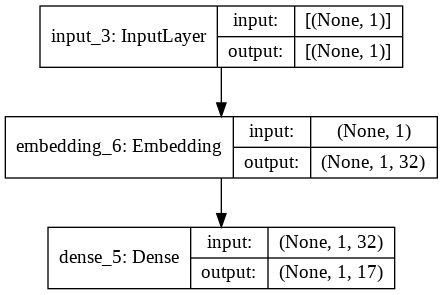

In [74]:
# 모델 생성
model, V = build_model(len(word_to_id), 32)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [75]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
plot_embdeeding(V, word_to_id)

In [ ]:
epochs = 100
# 20번 반복 진행
for i in range(20):
    # epoch 학습 진행 후 vector를 화면에 출력
    model.fit(train_token_ids, train_label_ids, batch_size=512, epochs=epochs, verbose=0)
    print(f"training >>> {(i+1) * epochs}")
    plot_embdeeding(V, word_to_id)

# Gensim
- https://radimrehurek.com/gensim/index.html

In [79]:
import gensim
import gensim.downloader as api

## Tutorial

In [80]:
# 이미 학습된 model download
# wv = api.load('word2vec-google-news-300') # 1.6G
wv = api.load('glove-wiki-gigaword-100') # 128M

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# vocab 개수 및 최초 20개 출력
print(f"len: {len(wv.vocab)}")
for i, word in enumerate(wv.vocab):
    if i >= 20:
        break
    print(f"{i:2d}: {word}")

In [ ]:
wv.most_similar('obama')

In [ ]:
wv.most_similar('banana')

In [ ]:
wv.most_similar('apple')

In [ ]:
# king - man + woman by
result = wv.most_similar(positive=['woman', 'king'], negative=['man'])
result

In [87]:
def analogy(p1, n1, p2):
    result = wv.most_similar(positive=[p2, p1], negative=[n1])
    return result

In [ ]:
# japanese - japan + australia
analogy('japanese', 'japan', 'australia')

In [ ]:
# beer - australia + france
analogy('beer', 'australia', 'france')

In [90]:
# clinton - reagan + obama
analogy('clinton', 'reagan', 'obama')

[('barack', 0.8189094066619873),
 ('bush', 0.7976235151290894),
 ('mccain', 0.7815861701965332),
 ('gore', 0.7276442050933838),
 ('hillary', 0.7135353088378906),
 ('rodham', 0.6994726657867432),
 ('romney', 0.6853622198104858),
 ('dole', 0.6626838445663452),
 ('kerry', 0.6506499648094177),
 ('republicans', 0.6442651152610779)]

In [91]:
# tallest - tall + long
analogy('tallest', 'tall', 'long')

[('longest', 0.7037104964256287),
 ('the', 0.6229448914527893),
 ('major', 0.6216300129890442),
 ('time', 0.6173369884490967),
 ('first', 0.616451621055603),
 ('since', 0.60569828748703),
 ('decade', 0.6019695997238159),
 ('busiest', 0.600587785243988),
 ('its', 0.6004385352134705),
 ('part', 0.60023432970047)]

In [92]:
# fantastic - good + bad
analogy('fantastic', 'good', 'bad')

[('terrible', 0.7074226140975952),
 ('awful', 0.70609450340271),
 ('horrible', 0.6906466484069824),
 ('scary', 0.6802915334701538),
 ('weird', 0.6775556206703186),
 ('crazy', 0.6615543365478516),
 ('strange', 0.6522735953330994),
 ('dreadful', 0.6404813528060913),
 ('bizarre', 0.6389496922492981),
 ('incredible', 0.6321425437927246)]

In [99]:
wv.doesnt_match("cup bowl dinner candle".split())

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'candle'

In [94]:
def display_pca_scatterplot(model, words=None, n_sample=100):
    if not words:
        words = np.random.choice(list(model.vocab.keys()), n_sample)
    word_vectors = np.array([model[w] for w in words])

    # 폰트
    font_name = "NanumBarunGothic"

    # plot 크기 및 폰트 설정
    plt.rc('font', family=font_name)
    plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결

    word_vectors = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(12,12))
    plt.scatter(word_vectors[:,0], word_vectors[:,1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, word_vectors):
        plt.text(x, y, word)
    plt.show()

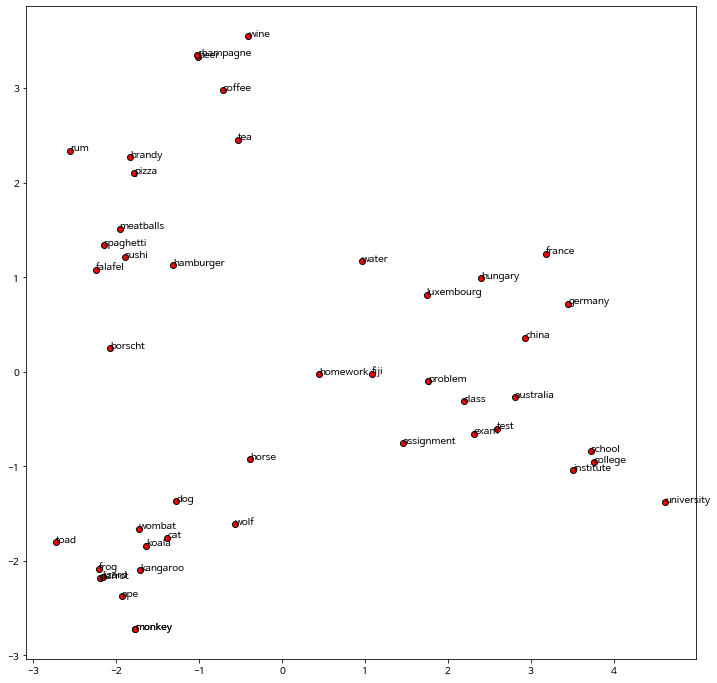

In [95]:
display_pca_scatterplot(wv, words=['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 257 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 257 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0, flags=flags)


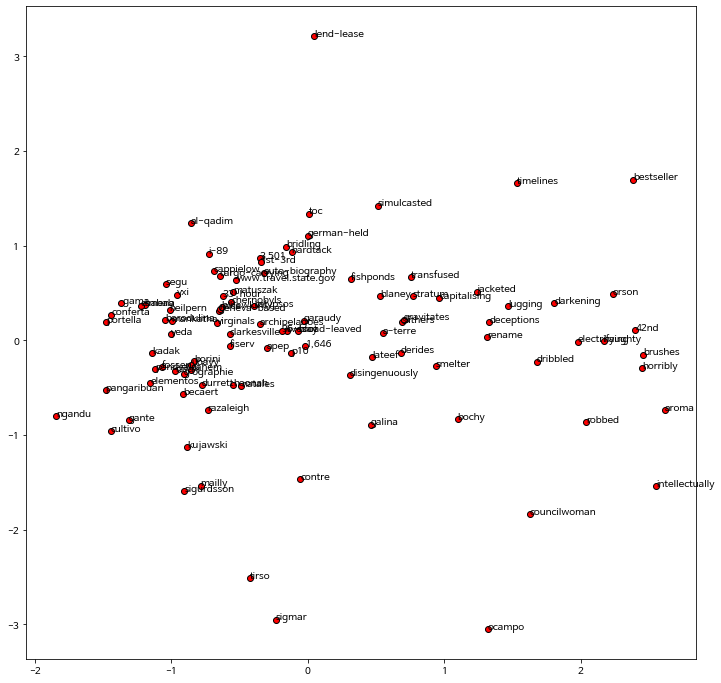

In [100]:
display_pca_scatterplot(wv)